In [46]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Define file paths
jobs_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - CONTRACTED JOBS.csv'
logs_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - LOGS.csv'
labs_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - LABS.csv'
reocc_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - REOCCUPANCY.csv'

# Load raw data
jobs = pd.read_csv(jobs_path)
logs = pd.read_csv(logs_path)
labs = pd.read_csv(labs_path)
reocc = pd.read_csv(reocc_path)

# Step 2: Clean DataFrames
# Clean JOBS
jobs['JOBID'] = jobs['JOBID'].astype(str)
jobs['CONTRACTID'] = jobs['CONTRACTID'].astype(str)
jobs['BID'] = jobs['BID'].astype(str)
jobs['SCHOOL NAME'] = jobs['SCHOOL NAME'].astype(str)
jobs['WA #'] = jobs['WA #'].astype(str)
jobs['SID'] = jobs['SID'].astype(str)
jobs['PROJECT TYPE'] = jobs['PROJECT TYPE'].astype(str)
jobs['PRIMARY HYGIENCIST'] = jobs['PRIMARY HYGIENCIST'].astype(str)
jobs['SERVICE NAME'] = jobs['SERVICE NAME'].astype(str)
jobs['WA TYPE'] = jobs['WA TYPE'].astype(str)
jobs['WA STATUS'] = jobs['WA STATUS'].astype(str)
jobs['INITIATION DATE'] = pd.to_datetime(jobs['INITIATION DATE'], errors='coerce')
jobs['ESTIMATED COST'] = pd.to_numeric(jobs['ESTIMATED COST'].str.replace('$', '').str.replace(',', ''), errors='coerce')
jobs['START DATE'] = pd.to_datetime(jobs['START DATE'], errors='coerce')
jobs['END DATE'] = pd.to_datetime(jobs['END DATE'], errors='coerce')
jobs['RFPID'] = jobs['RFPID'].astype(str).replace('nan', 'None')
jobs['DATE OF RFP'] = pd.to_datetime(jobs['DATE OF RFP'], errors='coerce')
jobs['AMOUNT INVOICED'] = pd.to_numeric(jobs['AMOUNT INVOICED'].str.replace('$', '').str.replace(',', ''), errors='coerce')
jobs['AMOUNT RECEIVED'] = pd.to_numeric(jobs['AMOUNT RECEIVED'].str.replace('$', '').str.replace(',', ''), errors='coerce')
jobs['DATE ON CHECK'] = pd.to_datetime(jobs['DATE ON CHECK'], errors='coerce')
jobs['PAID / UNPAID'] = jobs['PAID / UNPAID'].astype(str)

# Clean LOGS
logs['JOBID'] = logs['JOBID'].astype(str)
logs['BID'] = logs['BID'].astype(str)
logs['SID'] = logs['SID'].astype(str)
logs['TECHNICIAN'] = logs['TECHNICIAN'].astype(str)
logs['TITLE'] = logs['TITLE'].astype(str).str.strip()
logs['DATE WORKED'] = pd.to_datetime(logs['DATE WORKED'], errors='coerce')
logs['START TIME'] = pd.to_datetime(logs['START TIME'], format='%H:%M', errors='coerce')
logs['END TIME'] = pd.to_datetime(logs['END TIME'], format='%H:%M', errors='coerce')

def calculate_hours(row):
    start = row['START TIME']
    end = row['END TIME']
    if pd.isna(start) or pd.isna(end):
        return 0.0
    start_td = pd.Timedelta(hours=start.hour, minutes=start.minute)
    end_td = pd.Timedelta(hours=end.hour, minutes=end.minute)
    if end_td < start_td:  # Midnight crossover
        hours = (end_td + pd.Timedelta(hours=24) - start_td).total_seconds() / 3600
    else:
        hours = (end_td - start_td).total_seconds() / 3600
    return hours

logs['HOURS WORKED'] = logs.apply(calculate_hours, axis=1)
logs['TRAVEL TIME'] = pd.to_numeric(logs['TRAVEL TIME'], errors='coerce').fillna(0.0)
logs['START TIME'] = logs['START TIME'].dt.time
logs['END TIME'] = logs['END TIME'].dt.time

# Clean LABS
labs['JOBID'] = labs['JOBID'].astype(str)
labs['BID'] = labs['BID'].astype(str)
labs['SID'] = labs['SID'].astype(str)
labs['# OF SAMPLES'] = pd.to_numeric(labs['# OF SAMPLES'], errors='coerce')
labs['BATCH NO'] = labs['BATCH NO'].astype(str)
labs['SAMPLE TYPE'] = labs['SAMPLE TYPE'].astype(str)
labs['DATE COLLECTED'] = pd.to_datetime(labs['DATE COLLECTED'], errors='coerce')
labs['LAB FACILITY'] = labs['LAB FACILITY'].astype(str)
labs['LOCATION'] = labs['LOCATION'].astype(str)
labs['STATUS'] = labs['STATUS'].astype(str)

# Clean REOCCUPANCY
reocc['JOBID'] = reocc['JOBID'].astype(str)
reocc['BID'] = reocc['BID'].astype(str)
reocc['SID'] = reocc['SID'].astype(str)
reocc['START DATE'] = pd.to_datetime(reocc['START DATE'], errors='coerce')
reocc['END DATE'] = pd.to_datetime(reocc['END DATE'], errors='coerce')
reocc['LOCATION'] = reocc['LOCATION'].astype(str)
reocc['AMOUNT OF ACM'] = pd.to_numeric(reocc['AMOUNT OF ACM'], errors='coerce')

# Step 3: Define Cost Dictionaries and Calculate Costs
ALLAB_Cost = {
    'Backgrounds': 7, 'Pre': 7, 'Durings': 7, 'Durings as Finals': 8,
    'Finals': 8, 'TEM': 9, 'PLM': 10, 'PLM_NOB': 12, 'PLM_TEM': 13, 'Slide Prep': 2
}
LTS_Cost = {
    'Backgrounds': 6, 'Pre': 6, 'Durings': 6, 'Durings as Finals': 7,
    'Finals': 7, 'TEM': 8, 'PLM': 9, 'PLM_NOB': 10, 'PLM_TEM': 11, 'Slide Prep': 2
}
TECHNICIAN_RATE = {
    'INVESTIGATOR': 45,
    'INSPECTOR': 45,
    'PROJECT MONITOR A': 38,
    'PROJECT MONITOR B': 35,
    'PROJECT MONITOR C': 30
}

# Calculate labor costs in LOGS using TITLE
def get_technician_rate(title):
    title = title.strip()
    if title == 'INVESTIGATOR':
        return TECHNICIAN_RATE['INVESTIGATOR']
    if title == 'INSPECTOR':
        return TECHNICIAN_RATE['INSPECTOR']
    if 'PROJECT MONITOR' in title:
        if title == 'PROJECT MONITOR A':
            return TECHNICIAN_RATE['PROJECT MONITOR A']
        if title == 'PROJECT MONITOR B':
            return TECHNICIAN_RATE['PROJECT MONITOR B']
        if title == 'PROJECT MONITOR C':
            return TECHNICIAN_RATE['PROJECT MONITOR C']
    return 0

logs['HOURLY RATE'] = logs['TITLE'].apply(get_technician_rate)
logs['LABOR COST'] = logs['HOURS WORKED'] * logs['HOURLY RATE']

# Calculate sample costs in LABS
def calculate_sample_cost(row):
    lab = row['LAB FACILITY']
    sample_type = row['SAMPLE TYPE']
    num_samples = row['# OF SAMPLES']
    cost_dict = ALLAB_Cost if lab == 'ALLAB' else LTS_Cost
    cost_per_sample = cost_dict.get(sample_type, 0)
    return cost_per_sample * num_samples

labs['SAMPLE COST'] = labs.apply(calculate_sample_cost, axis=1)

# Step 4: Merge Data for Dashboard
# Start with JOBS for JOBID, SCHOOL NAME, RFPID
dashboard_data = jobs[['JOBID', 'SCHOOL NAME', 'RFPID']].copy()

# Merge with REOCCUPANCY for START DATE, END DATE, AMOUNT OF ACM
dashboard_data = dashboard_data.merge(
    reocc[['JOBID', 'START DATE', 'END DATE', 'LOCATION', 'AMOUNT OF ACM']],
    on='JOBID', how='left'
)

# Aggregate LOGS: Technicians, total hours, and labor cost per job
logs_agg = logs.groupby('JOBID').agg({
    'TECHNICIAN': lambda x: ', '.join(x.unique()),
    'HOURS WORKED': 'sum',
    'LABOR COST': 'sum'
}).reset_index()

dashboard_data = dashboard_data.merge(logs_agg, on='JOBID', how='left')

# Aggregate LABS: Sample types, total samples, and sample cost per job
labs_agg = labs.groupby('JOBID').agg({
    'SAMPLE TYPE': lambda x: ', '.join(x.unique()),
    '# OF SAMPLES': 'sum',
    'SAMPLE COST': 'sum'
}).reset_index()

dashboard_data = dashboard_data.merge(labs_agg, on='JOBID', how='left')

# Calculate total cost (labor + samples)
dashboard_data['TOTAL COST'] = (dashboard_data['LABOR COST'].fillna(0) + 
                              dashboard_data['SAMPLE COST'].fillna(0))

# Display the dashboard data
print("\nDashboard Data:")
print(dashboard_data.head())


Dashboard Data:
      JOBID                       SCHOOL NAME   RFPID START DATE END DATE  \
0  17SD-136  LOUIS D. BRANDEIS HS - MANHATTAN   230.0        NaT      NaT   
1   19S-261                P.S. 11 - BROOKLYN  4200.0        NaT      NaT   
2   21S-102                I.S. 61 - BROOKLYN  4196.0        NaT      NaT   
3   19S-010               P.S. 110 - BROOKLYN  4184.0        NaT      NaT   
4   22S-083               P.S. 163 - BROOKLYN    None        NaT      NaT   

  LOCATION  AMOUNT OF ACM TECHNICIAN  HOURS WORKED  LABOR COST SAMPLE TYPE  \
0      NaN            NaN        NaN           NaN         NaN         NaN   
1      NaN            NaN        NaN           NaN         NaN         NaN   
2      NaN            NaN        NaN           NaN         NaN         NaN   
3      NaN            NaN        NaN           NaN         NaN         NaN   
4      NaN            NaN        NaN           NaN         NaN         NaN   

   # OF SAMPLES  SAMPLE COST  TOTAL COST  
0       

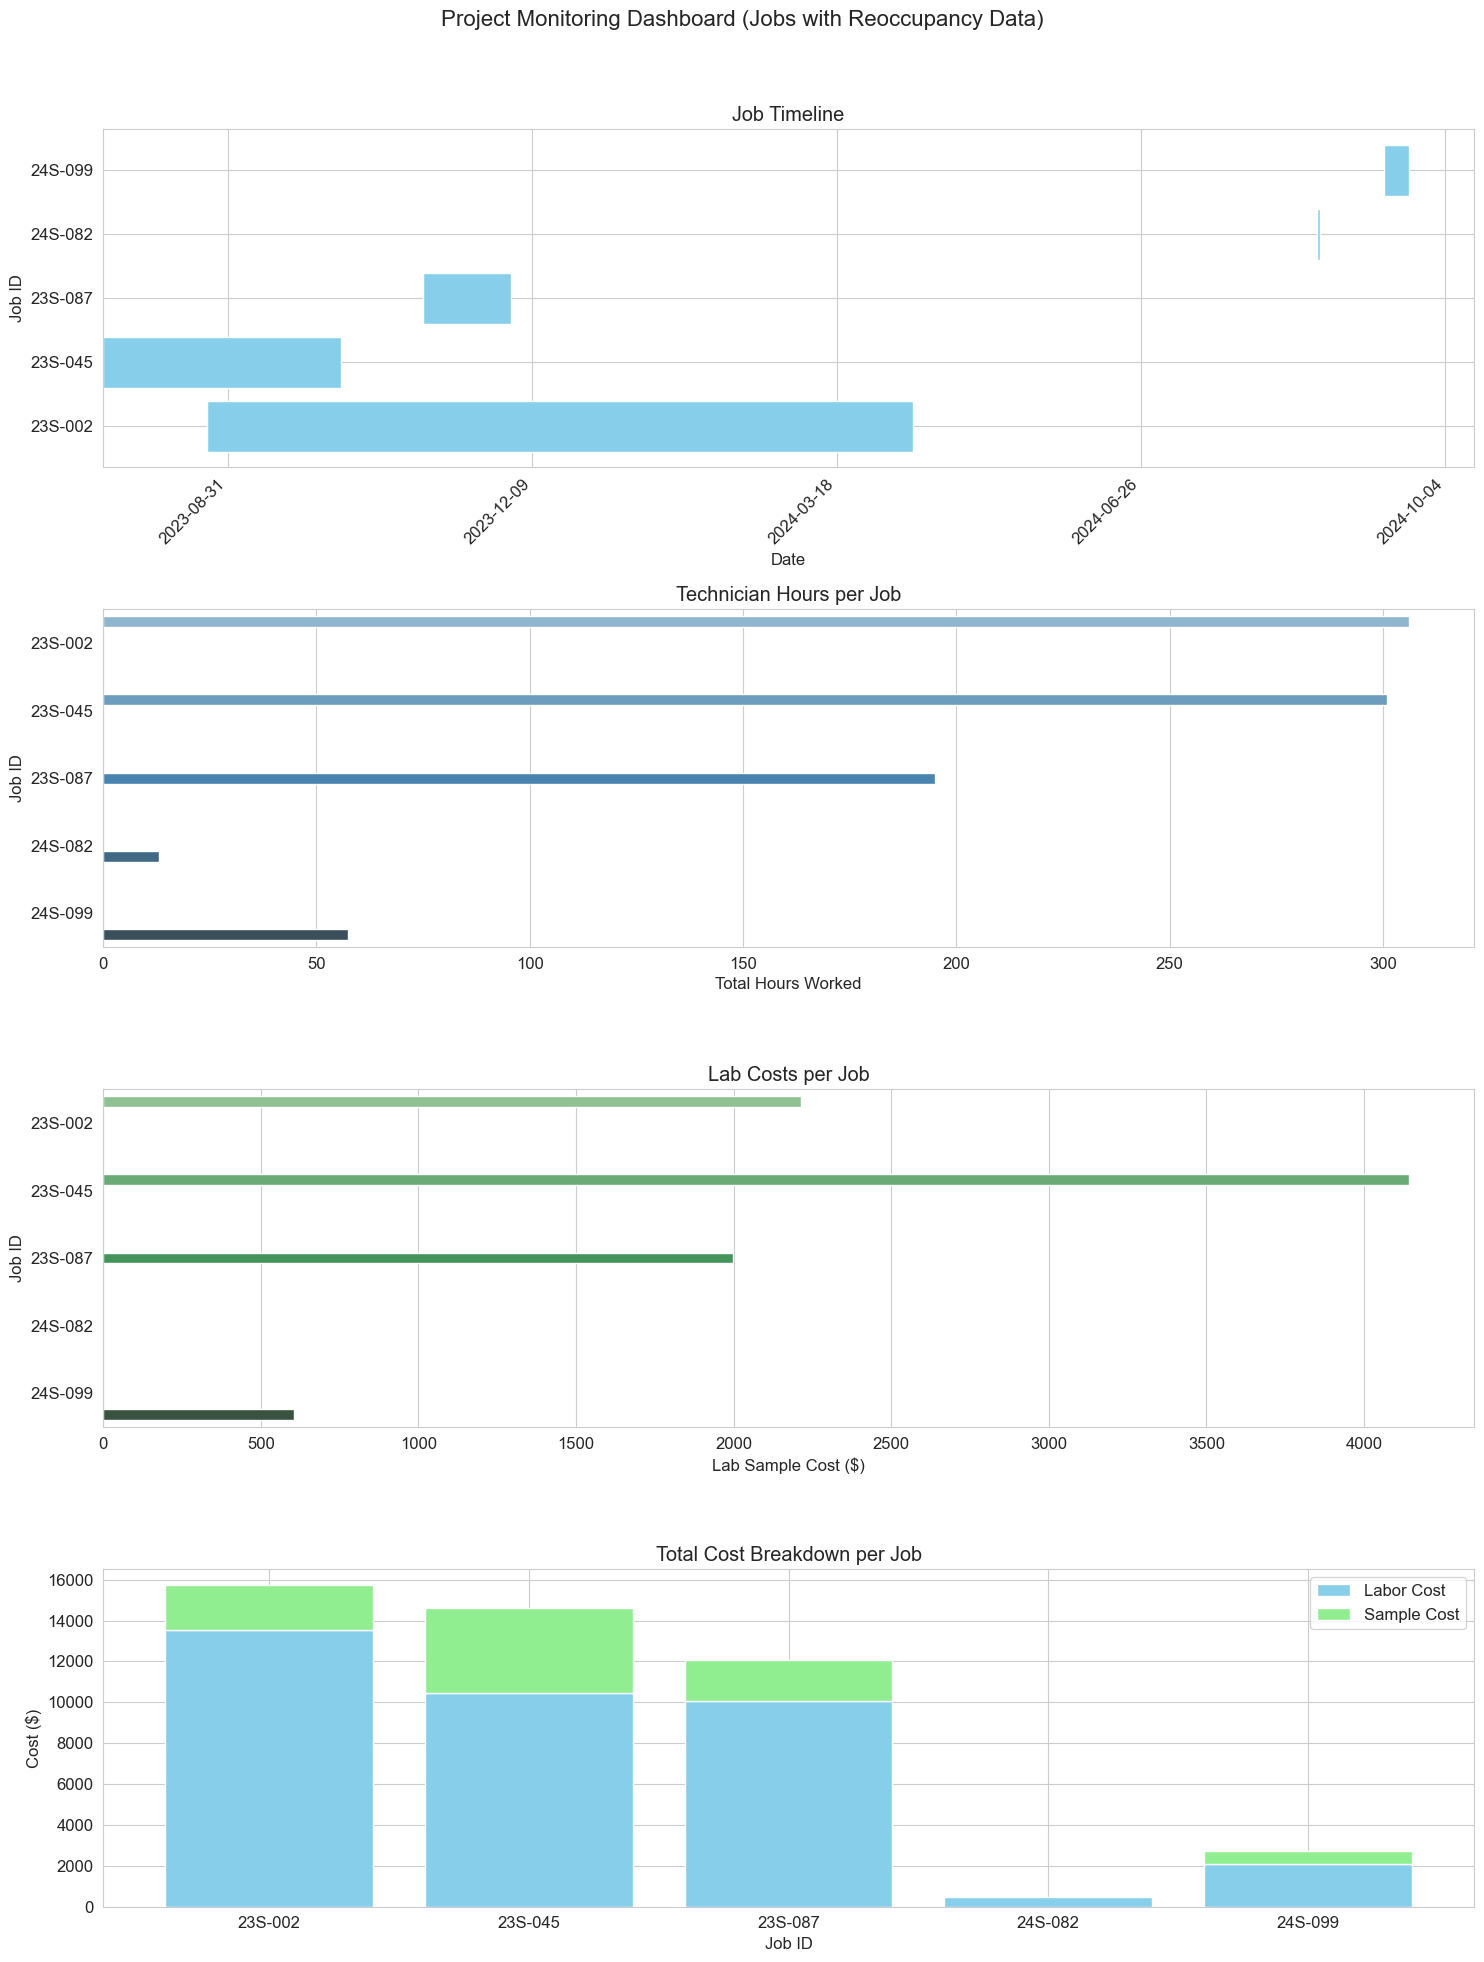


Aggregated Dashboard Data (Jobs with Reoccupancy Data):
     JOBID                                SCHOOL NAME  RFPID START DATE  \
0  23S-002   NEWCOMERS HIGH SCHOOL (OLD LIC) - QUEENS   None 2023-08-24   
1  23S-045                       P.S. 115 - MANHATTAN   None 2023-07-21   
2  23S-087                        P.S. 110 - BROOKLYN   None 2023-11-03   
3  24S-082                        I.S. 246 - BROOKLYN   None 2024-08-23   
4  24S-099  STATEN ISLAND TECHNIAL HS - STATEN ISLAND  146.0 2024-09-14   

    END DATE                                           LOCATION  \
0 2024-04-12  BSMT RM B7, B9, BSMT RM B9, RM 219,129,014,015...   
1 2023-10-07  1ST FL KITCHEN STAFF BATHRM, STAIR 6, 8, 4TH F...   
2 2023-12-02  2ND FL CORRIDOR  , 3RD FL RM 303, 3RD FL RM 30...   
3 2024-08-24                                        RM 127, B30   
4 2024-09-22                                     1ST FL  , BSMT   

   AMOUNT OF ACM                                         TECHNICIAN  \
0        11477.0  

In [50]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Define file paths
jobs_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - CONTRACTED JOBS.csv'
logs_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - LOGS.csv'
labs_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - LABS.csv'
reocc_path = '/Users/patriciaquigley/Desktop/JobAnalytics/MY-DATABASE - REOCCUPANCY.csv'

# Load raw data
jobs = pd.read_csv(jobs_path)
logs = pd.read_csv(logs_path)
labs = pd.read_csv(labs_path)
reocc = pd.read_csv(reocc_path)

# Step 2: Clean DataFrames
# Clean JOBS
jobs['JOBID'] = jobs['JOBID'].astype(str)
jobs['CONTRACTID'] = jobs['CONTRACTID'].astype(str)
jobs['BID'] = jobs['BID'].astype(str)
jobs['SCHOOL NAME'] = jobs['SCHOOL NAME'].astype(str)
jobs['WA #'] = jobs['WA #'].astype(str)
jobs['SID'] = jobs['SID'].astype(str)
jobs['PROJECT TYPE'] = jobs['PROJECT TYPE'].astype(str)
jobs['PRIMARY HYGIENCIST'] = jobs['PRIMARY HYGIENCIST'].astype(str)
jobs['SERVICE NAME'] = jobs['SERVICE NAME'].astype(str)
jobs['WA TYPE'] = jobs['WA TYPE'].astype(str)
jobs['WA STATUS'] = jobs['WA STATUS'].astype(str)
jobs['INITIATION DATE'] = pd.to_datetime(jobs['INITIATION DATE'], errors='coerce')
jobs['ESTIMATED COST'] = pd.to_numeric(jobs['ESTIMATED COST'].str.replace('$', '').str.replace(',', ''), errors='coerce')
jobs['START DATE'] = pd.to_datetime(jobs['START DATE'], errors='coerce')
jobs['END DATE'] = pd.to_datetime(jobs['END DATE'], errors='coerce')
jobs['RFPID'] = jobs['RFPID'].astype(str).replace('nan', 'None')
jobs['DATE OF RFP'] = pd.to_datetime(jobs['DATE OF RFP'], errors='coerce')
jobs['AMOUNT INVOICED'] = pd.to_numeric(jobs['AMOUNT INVOICED'].str.replace('$', '').str.replace(',', ''), errors='coerce')
jobs['AMOUNT RECEIVED'] = pd.to_numeric(jobs['AMOUNT RECEIVED'].str.replace('$', '').str.replace(',', ''), errors='coerce')
jobs['DATE ON CHECK'] = pd.to_datetime(jobs['DATE ON CHECK'], errors='coerce')
jobs['PAID / UNPAID'] = jobs['PAID / UNPAID'].astype(str)

# Clean LOGS
logs['JOBID'] = logs['JOBID'].astype(str)
logs['BID'] = logs['BID'].astype(str)
logs['SID'] = logs['SID'].astype(str)
logs['TECHNICIAN'] = logs['TECHNICIAN'].astype(str)
logs['TITLE'] = logs['TITLE'].astype(str).str.strip()
logs['DATE WORKED'] = pd.to_datetime(logs['DATE WORKED'], errors='coerce')
logs['START TIME'] = pd.to_datetime(logs['START TIME'], format='%H:%M', errors='coerce')
logs['END TIME'] = pd.to_datetime(logs['END TIME'], format='%H:%M', errors='coerce')

def calculate_hours(row):
    start = row['START TIME']
    end = row['END TIME']
    if pd.isna(start) or pd.isna(end):
        return 0.0
    start_td = pd.Timedelta(hours=start.hour, minutes=start.minute)
    end_td = pd.Timedelta(hours=end.hour, minutes=end.minute)
    if end_td < start_td:  # Midnight crossover
        hours = (end_td + pd.Timedelta(hours=24) - start_td).total_seconds() / 3600
    else:
        hours = (end_td - start_td).total_seconds() / 3600
    return hours

logs['HOURS WORKED'] = logs.apply(calculate_hours, axis=1)
logs['TRAVEL TIME'] = pd.to_numeric(logs['TRAVEL TIME'], errors='coerce').fillna(0.0)
logs['START TIME'] = logs['START TIME'].dt.time
logs['END TIME'] = logs['END TIME'].dt.time

# Clean LABS
labs['JOBID'] = labs['JOBID'].astype(str)
labs['BID'] = labs['BID'].astype(str)
labs['SID'] = labs['SID'].astype(str)
labs['# OF SAMPLES'] = pd.to_numeric(labs['# OF SAMPLES'], errors='coerce')
labs['BATCH NO'] = labs['BATCH NO'].astype(str)
labs['SAMPLE TYPE'] = labs['SAMPLE TYPE'].astype(str)
labs['DATE COLLECTED'] = pd.to_datetime(labs['DATE COLLECTED'], errors='coerce')
labs['LAB FACILITY'] = labs['LAB FACILITY'].astype(str)
labs['LOCATION'] = labs['LOCATION'].astype(str)
labs['STATUS'] = labs['STATUS'].astype(str)

# Clean REOCCUPANCY
reocc['JOBID'] = reocc['JOBID'].astype(str)
reocc['BID'] = reocc['BID'].astype(str)
reocc['SID'] = reocc['SID'].astype(str)
reocc['START DATE'] = pd.to_datetime(reocc['START DATE'], errors='coerce')
reocc['END DATE'] = pd.to_datetime(reocc['END DATE'], errors='coerce')
reocc['LOCATION'] = reocc['LOCATION'].astype(str)
reocc['AMOUNT OF ACM'] = pd.to_numeric(reocc['AMOUNT OF ACM'], errors='coerce')

# Step 3: Define Cost Dictionaries and Calculate Costs
ALLAB_Cost = {
    'Backgrounds': 7, 'Pre': 7, 'Durings': 7, 'Durings as Finals': 8,
    'Finals': 8, 'TEM': 9, 'PLM': 10, 'PLM_NOB': 12, 'PLM_TEM': 13, 'Slide Prep': 2
}
LTS_Cost = {
    'Backgrounds': 6, 'Pre': 6, 'Durings': 6, 'Durings as Finals': 7,
    'Finals': 7, 'TEM': 8, 'PLM': 9, 'PLM_NOB': 10, 'PLM_TEM': 11, 'Slide Prep': 2
}
TECHNICIAN_RATE = {
    'INVESTIGATOR': 128,
    'INSPECTOR': 114,
    'PROJECT MONITOR A': 38,
    'PROJECT MONITOR B': 35,
    'PROJECT MONITOR C': 30
}

# Calculate labor costs in LOGS using TITLE
def get_technician_rate(title):
    title = title.strip()
    if title == 'INVESTIGATOR':
        return TECHNICIAN_RATE['INVESTIGATOR']
    if title == 'INSPECTOR':
        return TECHNICIAN_RATE['INSPECTOR']
    if 'PROJECT MONITOR' in title:
        if title == 'PROJECT MONITOR A':
            return TECHNICIAN_RATE['PROJECT MONITOR A']
        if title == 'PROJECT MONITOR B':
            return TECHNICIAN_RATE['PROJECT MONITOR B']
        if title == 'PROJECT MONITOR C':
            return TECHNICIAN_RATE['PROJECT MONITOR C']
    return 0

logs['HOURLY RATE'] = logs['TITLE'].apply(get_technician_rate)
logs['LABOR COST'] = logs['HOURS WORKED'] * logs['HOURLY RATE']

# Calculate sample costs in LABS
def calculate_sample_cost(row):
    lab = row['LAB FACILITY']
    sample_type = row['SAMPLE TYPE']
    num_samples = row['# OF SAMPLES']
    cost_dict = ALLAB_Cost if lab == 'ALLAB' else LTS_Cost
    cost_per_sample = cost_dict.get(sample_type, 0)
    return cost_per_sample * num_samples

labs['SAMPLE COST'] = labs.apply(calculate_sample_cost, axis=1)

# Step 4: Merge Data for Dashboard
# Start with JOBS for JOBID, SCHOOL NAME, RFPID
dashboard_data = jobs[['JOBID', 'SCHOOL NAME', 'RFPID']].copy()

# Merge with REOCCUPANCY for START DATE, END DATE, AMOUNT OF ACM
dashboard_data = dashboard_data.merge(
    reocc[['JOBID', 'START DATE', 'END DATE', 'LOCATION', 'AMOUNT OF ACM']],
    on='JOBID', how='left'
)

# Aggregate LOGS: Technicians, total hours, and labor cost per job
logs_agg = logs.groupby('JOBID').agg({
    'TECHNICIAN': lambda x: ', '.join(x.unique()),
    'HOURS WORKED': 'sum',
    'LABOR COST': 'sum'
}).reset_index()

dashboard_data = dashboard_data.merge(logs_agg, on='JOBID', how='left')

# Aggregate LABS: Sample types, total samples, and sample cost per job
labs_agg = labs.groupby('JOBID').agg({
    'SAMPLE TYPE': lambda x: ', '.join(x.unique()),
    '# OF SAMPLES': 'sum',
    'SAMPLE COST': 'sum'
}).reset_index()

dashboard_data = dashboard_data.merge(labs_agg, on='JOBID', how='left')

# Calculate total cost (labor + samples)
dashboard_data['TOTAL COST'] = (dashboard_data['LABOR COST'].fillna(0) + 
                              dashboard_data['SAMPLE COST'].fillna(0))

# Filter to show only jobs with Reoccupancy data
reocc_dashboard = dashboard_data[dashboard_data['START DATE'].notna()]

# Aggregate by JOBID to remove duplicates
reocc_dashboard_agg = reocc_dashboard.groupby('JOBID').agg({
    'SCHOOL NAME': 'first',
    'RFPID': 'first',
    'START DATE': 'min',
    'END DATE': 'max',
    'LOCATION': lambda x: ', '.join(x),
    'AMOUNT OF ACM': 'sum',
    'TECHNICIAN': 'first',
    'HOURS WORKED': 'first',
    'LABOR COST': 'first',
    'SAMPLE TYPE': 'first',
    '# OF SAMPLES': 'first',
    'SAMPLE COST': 'first',
    'TOTAL COST': 'first'
}).reset_index()

# Handle NaN END DATE by setting it to START DATE for Gantt chart
reocc_dashboard_agg['END DATE'] = reocc_dashboard_agg['END DATE'].fillna(reocc_dashboard_agg['START DATE'])

# Step 5: Create Dashboard Visualizations
# Create a figure with subplots
fig = plt.figure(figsize=(15, 20))
fig.suptitle('Project Monitoring Dashboard (Jobs with Reoccupancy Data)', fontsize=16)

# 1. Timeline (Gantt Chart)
ax1 = fig.add_subplot(411)
reocc_dashboard_agg['Duration'] = (reocc_dashboard_agg['END DATE'] - reocc_dashboard_agg['START DATE']).dt.days
for idx, row in reocc_dashboard_agg.iterrows():
    ax1.barh(row['JOBID'], row['Duration'], left=row['START DATE'], color='skyblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Job ID')
ax1.set_title('Job Timeline')
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# 2. Technician Hours
ax2 = fig.add_subplot(412)
sns.barplot(data=reocc_dashboard_agg, x='HOURS WORKED', y='JOBID', hue='JOBID', palette='Blues_d', ax=ax2)
ax2.set_xlabel('Total Hours Worked')
ax2.set_ylabel('Job ID')
ax2.set_title('Technician Hours per Job')
ax2.get_legend().remove()  # Remove the legend

# 3. Lab Costs
ax3 = fig.add_subplot(413)
sns.barplot(data=reocc_dashboard_agg, x='SAMPLE COST', y='JOBID', hue='JOBID', palette='Greens_d', ax=ax3)
ax3.set_xlabel('Lab Sample Cost ($)')
ax3.set_ylabel('Job ID')
ax3.set_title('Lab Costs per Job')
ax3.get_legend().remove()  # Remove the legend

# 4. Total Cost Breakdown (Stacked Bar)
ax4 = fig.add_subplot(414)
ax4.bar(reocc_dashboard_agg['JOBID'], reocc_dashboard_agg['LABOR COST'], label='Labor Cost', color='skyblue')
ax4.bar(reocc_dashboard_agg['JOBID'], reocc_dashboard_agg['SAMPLE COST'], bottom=reocc_dashboard_agg['LABOR COST'], label='Sample Cost', color='lightgreen')
ax4.set_xlabel('Job ID')
ax4.set_ylabel('Cost ($)')
ax4.set_title('Total Cost Breakdown per Job')
ax4.legend()

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Display the aggregated data for reference
print("\nAggregated Dashboard Data (Jobs with Reoccupancy Data):")
print(reocc_dashboard_agg)